In [1]:
%autosave 0

Autosave disabled


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('..')

from lib.classifier_trainer import MainAiJob
from lib.data_explore import DataExplore
from lib import consume_validation

# Import ML modele packages
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

from sklearn import svm
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler

from joblib import dump

Using TensorFlow backend.


Local Sec Env loaded


In [4]:
df = pd.read_csv("../Data/app_hover_public.csv")

In [5]:
df.shape

(59472, 29)

In [6]:
pd.set_option('display.max_columns', 50)

In [7]:
df.sample(5)

,Steam_id,Title,Date_release,Evaluation,Nb_Eval,Nb_game_tags,Game_Tag_1,Game_Tag_2,Game_Tag_3,Game_Tag_4,Game_Tag_5,App_cat,Dev_team,Publisher_team,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price
47354,1049310,Backpack Twins,2019-08-16,No,0,16,Indie,Action,Platformer,Puzzle,Casual,Game,Tomás de Vicente,Tomás de Vicente,1,Indie,1,0,6,0,0,0,0,15,1,0,0,0,8.19
30170,742380,Spreadstorm,2018-06-13,Positive,11,20,Difficult,Isometric,Exploration,Puzzle,Minimalist,Game,unbeGames,unbeGames,4,Indie,1,0,9,0,0,0,0,24,1,0,0,0,0.00
9437,390340,Umbrella Corps,2016-06-21,Mostly Negative,774,20,Action,Zombies,Multiplayer,Shooter,Third-Person Shooter,Game,CAPCOM,CAPCOM,1,Action,1,0,25,0,0,0,0,41,1,0,1,0,14.99
53555,1166100,Danger Course VR,2019-11-11,No,0,19,Action,Adventure,Indie,Casual,VR,Game,Cesar G,Cesar G,1,Action,0,0,23,0,1,1,0,0,1,0,0,0,0.00
59281,1294140,Obey Me - Festive Events Skin Pack,2020-05-22,No,0,3,Action,Adventure,Indie,NaN,NaN,Downloadable Content,Error 404 Game Studios SA,Blowfish Studios,1,Action,1,1,9,0,0,0,0,0,1,0,1,0,0.00


# Data engineering

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59472 entries, 0 to 59471
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Steam_id            59472 non-null  int64  
 1   Title               59469 non-null  object 
 2   Date_release        59472 non-null  object 
 3   Evaluation          59472 non-null  object 
 4   Nb_Eval             59472 non-null  int64  
 5   Nb_game_tags        59472 non-null  int64  
 6   Game_Tag_1          59472 non-null  object 
 7   Game_Tag_2          55273 non-null  object 
 8   Game_Tag_3          47807 non-null  object 
 9   Game_Tag_4          38489 non-null  object 
 10  Game_Tag_5          31347 non-null  object 
 11  App_cat             59445 non-null  object 
 12  Dev_team            56931 non-null  object 
 13  Publisher_team      57492 non-null  object 
 14  Os_supported        59472 non-null  int64  
 15  Prymary_genre       58419 non-null  object 
 16  Cont

In [9]:
dataviz = DataExplore(df,'Nb_Eval')
dataviz.count_na()

,Total,Null_Count,Percent
Game_Tag_5,59472,28125,47.29
Game_Tag_4,59472,20983,35.28
Game_Tag_3,59472,11665,19.61
Game_Tag_2,59472,4199,7.06
Dev_team,59472,2541,4.27
Publisher_team,59472,1980,3.33
Prymary_genre,59472,1053,1.77
App_cat,59472,27,0.05
Title,59472,3,0.01


Notre target n'exite pas vraiment, on a des produits qui ont soit 0 evaluation soit X.

On va donc créer notre target et définire soit 0 pour 1 soit 1 pour X

In [10]:
def apply_status_reco(df):
    if df['Nb_Eval'] >= 1:
        return 1
    else:
        return 0
    
def apply_value_reco(df):
    """create Output phase 2 """
    if 'Positive' in df['Evaluation']:
        return 1
    else:
        return 0     

In [11]:
df['status_reco'] = df.apply(apply_status_reco, axis=1)
df['Value_reco'] = df.apply(apply_value_reco, axis=1)

In [12]:
df.columns

Index(['Steam_id', 'Title', 'Date_release', 'Evaluation', 'Nb_Eval',
       'Nb_game_tags', 'Game_Tag_1', 'Game_Tag_2', 'Game_Tag_3', 'Game_Tag_4',
       'Game_Tag_5', 'App_cat', 'Dev_team', 'Publisher_team', 'Os_supported',
       'Prymary_genre', 'Controller_support', 'Is_free_app', 'Nb_language',
       'Workshop_visible', 'Only_vr_support', 'Vr_support',
       'Has_adult_content', 'Nb_achievements', 'Single_player', 'Coop_player',
       'Multi_player', 'Early_Access', 'Price', 'status_reco', 'Value_reco'],
      dtype='object')

In [13]:
## drop les colonnes qui n'apportent pas de valeur à notre projet et remplacer les manquants, 
## mais aussi les colonnes qu'ont aura pas au moment de la prediction (les game tag) et surtout celles qui apportent un élément 
## de réponse par exemple si on garde la colonne qui dit que les revieuw sont trés positives, 
##ca veut dire qu'il y'en a il ne faut pas garder cette information.


df_clean = df.drop(columns=['Steam_id','Title', 'Date_release',
                            'Game_Tag_1','Game_Tag_2', 'Game_Tag_3', 'Game_Tag_4', 'Game_Tag_5',
                           'Nb_game_tags'])


In [14]:
df_clean["App_cat"].unique()

array(['Game', 'Legacy Media', 'Application', 'Demo', 'Config', nan,
       'Downloadable Content', 'Tool', 'Music', 'Unknown', 'Video',
       'Series', 'Hardware'], dtype=object)

In [15]:
## parmis toute les categories on veut garder uniquement les jeux

df_clean = df_clean[df_clean["App_cat"].isin(["Game", "Downloadable Content",  "Demo"])]

In [16]:
## je transforme les colonnes dev et publisher en information utilisable, au lieu du nom on prend le nombres de produits
## publiés.

df_clean['exp_dev_team'] = df_clean.groupby('Dev_team')['Dev_team'].transform('count')
df_clean['exp_publish_team'] = df_clean.groupby('Publisher_team')['Publisher_team'].transform('count')

In [17]:
## je rajoute une colonne, si les dev et publisher sont les même = 1 sinon 0 (édité par un tier)
def apply_self_editing(df):
    """create feature self editing """
    if df['Dev_team'] == df['Publisher_team']:
        return 1
    else:
        return 0

In [18]:
df_clean['Self_editor'] = df_clean.apply(apply_self_editing, axis=1)

In [19]:
## je fixe mes values pour le fillna

values = {'exp_dev_team': 0, 'exp_publish_team': 0, 'Prymary_genre': 'Unknown Genre', 'App_cat': 'Unknown'}
df_clean = df_clean.fillna(value=values);

In [20]:
## et je ne conserve pas ces cat 
df_clean = df_clean.drop(columns=['Dev_team','Publisher_team'])

In [21]:
df_clean.columns

Index(['Evaluation', 'Nb_Eval', 'App_cat', 'Os_supported', 'Prymary_genre',
       'Controller_support', 'Is_free_app', 'Nb_language', 'Workshop_visible',
       'Only_vr_support', 'Vr_support', 'Has_adult_content', 'Nb_achievements',
       'Single_player', 'Coop_player', 'Multi_player', 'Early_Access', 'Price',
       'status_reco', 'Value_reco', 'exp_dev_team', 'exp_publish_team',
       'Self_editor'],
      dtype='object')

In [22]:
convert_to_bool = ["Controller_support","Is_free_app","Workshop_visible","Only_vr_support",
                   "Vr_support","Has_adult_content",'Single_player',
                  'Coop_player', 'Multi_player', 'Early_Access','Self_editor']

for col in convert_to_bool:
    df_clean[col] = df_clean[col].astype('bool')

In [24]:
# Example du schema de data final 
df_clean.sample()

,Evaluation,Nb_Eval,App_cat,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price,status_reco,Value_reco,exp_dev_team,exp_publish_team,Self_editor
23533,Very Positive,58186,Game,1,Action,False,False,11,False,False,False,True,38,False,True,True,False,24.99,1,1,2.0,2.0,True


# Data exploration

In [25]:
dataviz = DataExplore(df_clean,'status_reco')

In [26]:
dataviz.count_na()

,Total,Null_Count,Percent


In [27]:
df_clean.shape

(54444, 23)

In [28]:
corr = df_clean.corr().abs()
corr.status_reco[corr.status_reco >= 0.01].sort_values(ascending=False)

status_reco           1.000000
Value_reco            0.714019
exp_dev_team          0.170124
exp_publish_team      0.154685
Nb_language           0.154026
Is_free_app           0.140943
Price                 0.140343
Self_editor           0.128467
Workshop_visible      0.117089
Single_player         0.110056
Nb_achievements       0.075832
Controller_support    0.067083
Coop_player           0.061259
Os_supported          0.057727
Multi_player          0.039201
Nb_Eval               0.035117
Early_Access          0.032115
Has_adult_content     0.030820
Only_vr_support       0.019072
Name: status_reco, dtype: float64

In [29]:
cols_cat = dataviz._infer_cat_columns()
cols_cat.remove('Evaluation')
cols_cat 

['App_cat',
 'Prymary_genre',
 'Controller_support',
 'Is_free_app',
 'Workshop_visible',
 'Only_vr_support',
 'Vr_support',
 'Has_adult_content',
 'Single_player',
 'Coop_player',
 'Multi_player',
 'Early_Access',
 'Self_editor']

In [30]:
col_num = dataviz._infer_num_columns()
col_num.remove("Nb_Eval")
col_num.remove("status_reco")
col_num.remove("Value_reco")
col_num

['Os_supported',
 'Nb_language',
 'Nb_achievements',
 'Price',
 'exp_dev_team',
 'exp_publish_team']

In [31]:
data_dummies, col_dum = dataviz._infer_dummies_columns()
col_dum

Index(['Controller_support', 'Is_free_app', 'Workshop_visible',
       'Only_vr_support', 'Vr_support', 'Has_adult_content', 'Single_player',
       'Coop_player', 'Multi_player', 'Early_Access', 'Self_editor',
       'Evaluation_Mostly Negative', 'Evaluation_Mostly Positive',
       'Evaluation_Negative', 'Evaluation_No',
       'Evaluation_Overwhelmingly Negative',
       'Evaluation_Overwhelmingly Positive', 'Evaluation_Positive',
       'Evaluation_Very Negative', 'Evaluation_Very Positive',
       'App_cat_Downloadable Content', 'App_cat_Game',
       'Prymary_genre_Adventure', 'Prymary_genre_Animation & Modeling',
       'Prymary_genre_Audio Production', 'Prymary_genre_Casual',
       'Prymary_genre_Design & Illustration', 'Prymary_genre_Early Access',
       'Prymary_genre_Education', 'Prymary_genre_Free to Play',
       'Prymary_genre_Game Development', 'Prymary_genre_Gore',
       'Prymary_genre_Indie', 'Prymary_genre_Massively Multiplayer',
       'Prymary_genre_Nudity', 'Pry

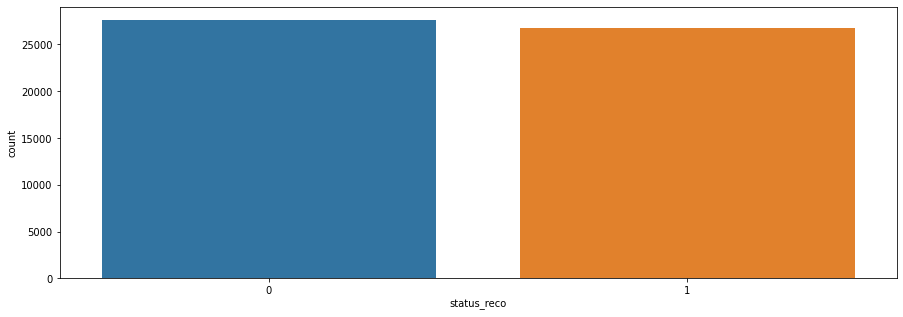

Nombres de sujet positifs :  26787  = 49.2 %
Nombres de sujet negatifs :  27657  = 50.8 %


In [32]:
panel_pos, panel_neg = dataviz.distribution_binaries()

In [33]:
# dataviz.all_num_features_distribution(show_outliers=False)

In [34]:
# dataviz.all_dum_features_distribution()

# Modelisation

In [35]:
df_ph1 = df_clean.drop(columns=["Evaluation", "Nb_Eval", "Value_reco"])

In [36]:
## select dic of model
dict_models ={"Random Forest ":RandomForestClassifier(),
              "Gradient Boosting Classifier": GradientBoostingClassifier(),
              "AdaBoost Classifier": AdaBoostClassifier(),
              "XgBoost": xgb.XGBClassifier(),
              "Bagging" : BaggingClassifier(),
#               "Decision Tree": DecisionTreeClassifier()
             }

## define var's for our class
test_size = 0.3 
random_state = 147


*********  Random Forest   *********

Score train : 0.98
-----------
Score test : 0.77
-----------
AUC: 0.81 (std:0.0212), (splits = 3)


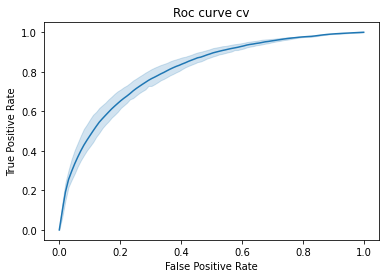

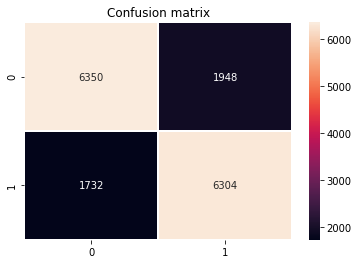

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      8298
           1       0.76      0.78      0.77      8036

    accuracy                           0.77     16334
   macro avg       0.77      0.77      0.77     16334
weighted avg       0.77      0.77      0.77     16334


*********  Gradient Boosting Classifier  *********

Score train : 0.78
-----------
Score test : 0.77
-----------
AUC: 0.83 (std:0.0259), (splits = 3)


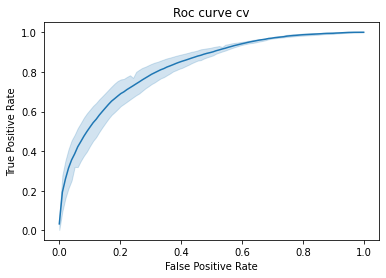

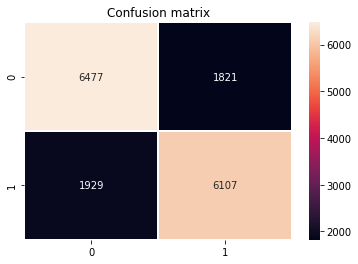

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      8298
           1       0.77      0.76      0.77      8036

    accuracy                           0.77     16334
   macro avg       0.77      0.77      0.77     16334
weighted avg       0.77      0.77      0.77     16334


*********  AdaBoost Classifier  *********

Score train : 0.76
-----------
Score test : 0.75
-----------
AUC: 0.82 (std:0.0305), (splits = 3)


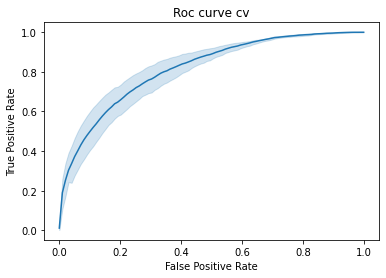

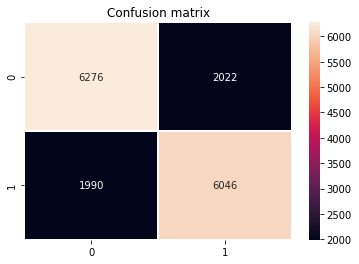

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      8298
           1       0.75      0.75      0.75      8036

    accuracy                           0.75     16334
   macro avg       0.75      0.75      0.75     16334
weighted avg       0.75      0.75      0.75     16334


*********  XgBoost  *********

Score train : 0.77
-----------
Score test : 0.77
-----------
AUC: 0.83 (std:0.0284), (splits = 3)


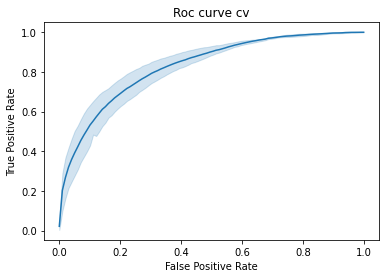

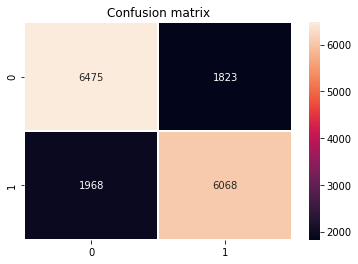

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      8298
           1       0.77      0.76      0.76      8036

    accuracy                           0.77     16334
   macro avg       0.77      0.77      0.77     16334
weighted avg       0.77      0.77      0.77     16334


*********  Bagging  *********

Score train : 0.97
-----------
Score test : 0.76
-----------
AUC: 0.78 (std:0.0163), (splits = 3)


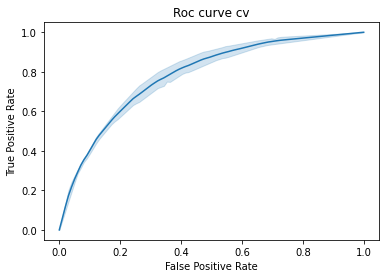

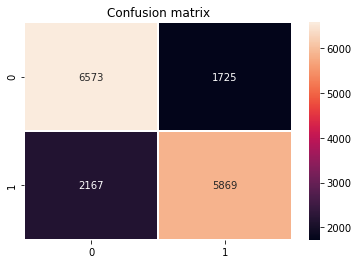

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      8298
           1       0.77      0.73      0.75      8036

    accuracy                           0.76     16334
   macro avg       0.76      0.76      0.76     16334
weighted avg       0.76      0.76      0.76     16334



In [38]:
for name, model in dict_models.items():
    print("")
    print("********* ",name," *********")
    print("")
    model_fited, _ = MainAiJob(model, df_ph1, target_name='status_reco', categorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=False, normalize=True,
                        list_col_name_drop=None,show_explainers=False, calibrate_model=False)

In [81]:
model_selec = GradientBoostingClassifier()

Score train : 0.77
-----------
Score test : 0.77
-----------
AUC: 0.83 (std:0.0268), (splits = 3)


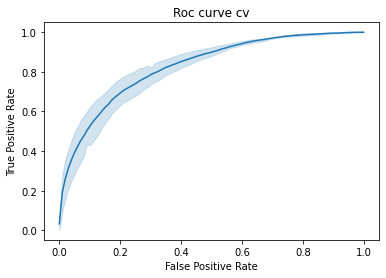

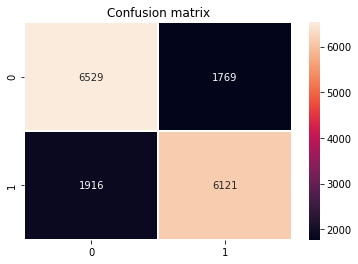

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      8298
           1       0.78      0.76      0.77      8037

    accuracy                           0.77     16335
   macro avg       0.77      0.77      0.77     16335
weighted avg       0.77      0.77      0.77     16335



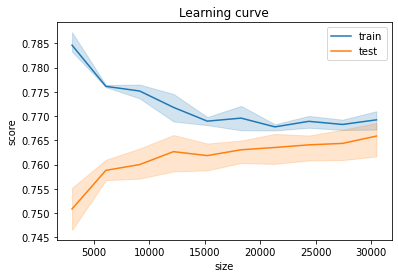

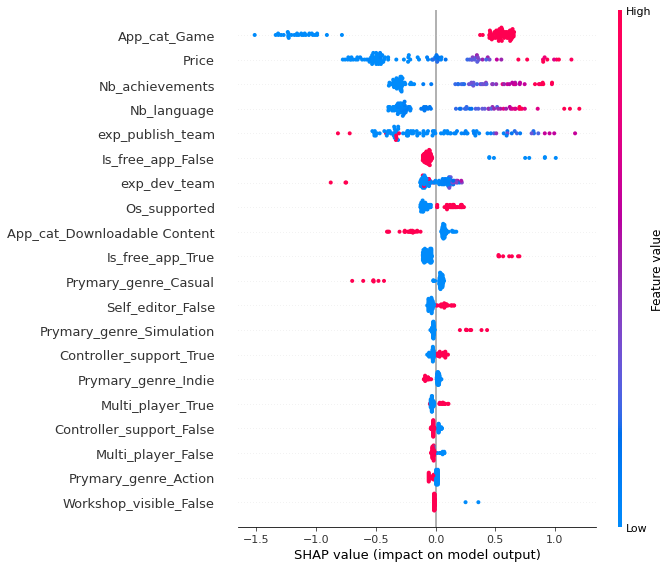

In [82]:
model_fited, core = MainAiJob(model_selec, df_ph1, target_name='status_reco', categorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=True, normalize=True,
                        list_col_name_drop=None,show_explainers=True, calibrate_model=False)

In [83]:
model_fited

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Os_supported',
                                                   'Nb_language',
                                                   'Nb_achievements', 'Price',
                                                   'exp_dev_team',
                                                   'exp_publish_team']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['App_cat', 'Prymary_genre',
                                                   'Controller_support

In [84]:
model_fited.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__scaler', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__onehot', 'preprocessor__cat__onehot__categories', 'preprocessor__cat__onehot__drop', 'preprocessor__cat__onehot__dtype', 'preprocessor__cat__onehot__handle_unknown', 'preprocessor__cat__onehot__sparse', 'model__ccp_alpha', 'model__criterion', 'model__init', 'model__learning_rate', 'model__loss', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__min_i

In [85]:
hyper_params = {"model__max_depth":[3,4,5],
                  "model__n_estimators":[100,300,500]}

scoring_metric = "accuracy"

def model_higther(pipeline,hyper_params,x_train,y_train,scoring_metric):
    
    train_x =  pipeline.named_steps['preprocessor'].transform(x_train)

    search = GridSearchCV(pipeline,hyper_params,scoring=scoring_metric, cv=3)
    search.fit(x_train, y_train)

    print(search.best_params_)

    Best_model = search.best_estimator_


    return Best_model

In [86]:
best_model = model_higther(model_fited,hyper_params,
                           core.get_X_train,core.get_y_train, scoring_metric)

{'model__max_depth': 5, 'model__n_estimators': 500}


In [87]:
model_selec_2 = GradientBoostingClassifier(n_estimators=500,max_depth=5)

Score train : 0.83
-----------
Score test : 0.79
-----------
AUC: 0.82 (std:0.0128), (splits = 3)


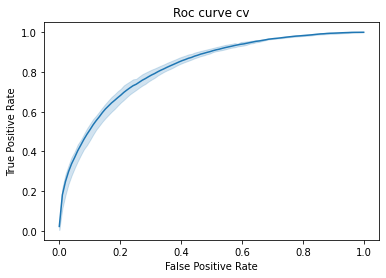

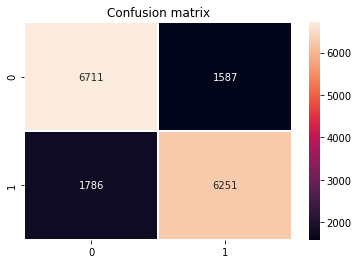

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      8298
           1       0.80      0.78      0.79      8037

    accuracy                           0.79     16335
   macro avg       0.79      0.79      0.79     16335
weighted avg       0.79      0.79      0.79     16335



KeyboardInterrupt: 

In [88]:
model_fited, core = MainAiJob(model_selec_2, df_ph1, target_name='status_reco', categorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=True, normalize=True,
                        list_col_name_drop=None,show_explainers=True, calibrate_model=False)

# Validation

In [ ]:
val_data = pd.read_csv("../Data/steam_val.csv", index_col=0)

In [ ]:
val_data

In [ ]:
val_data.shape

In [ ]:
y_val = [1,0]

In [ ]:
m_val_step = consume_validation.ConsumeModelClf(val_data,model_fited,validation=True,true_y=y_val)

m_val_step.predict_job()
final_df = m_val_step.show_result()
final_df

In [ ]:
m_val_step.explain(shap_mod=False, list_cat_features=cols_cat, list_num_features=col_num,
                   pipeline_is_normalized=True)

In [ ]:
dump_new = False

if dump_new:
    dump(model_fited,'../Model/gbc_f1.joblib')

# Phase 2

In [25]:
## This df will be used for create train/test on phase 2 & 3
df_ph2 = df_clean[df_clean["status_reco"].isin([1])]
df_ph2.shape 

(26787, 23)

In [26]:
df_ph2_clean = df_ph2.drop(['Nb_Eval','Evaluation','status_reco'], axis=1)
df_ph2_clean.sample()

,App_cat,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price,Value_reco,exp_dev_team,exp_publish_team,Self_editor
16977,Game,4,Action,True,False,3,False,False,False,False,6,True,False,True,False,0.99,1,3.0,63.0,False


<AxesSubplot:xlabel='Value_reco', ylabel='count'>

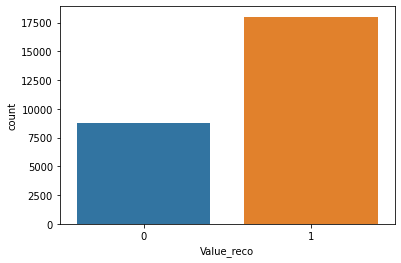

In [91]:
sns.countplot(df_ph2_clean['Value_reco'])


*********  Random Forest   *********

Score train : 0.98
-----------
Score test : 0.69
-----------
AUC: 0.63 (std:0.01), (splits = 3)


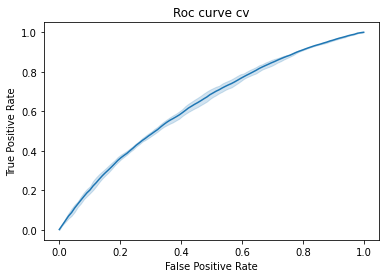

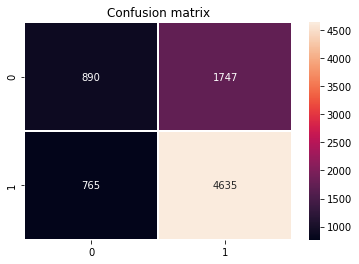

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.54      0.34      0.41      2637
           1       0.73      0.86      0.79      5400

    accuracy                           0.69      8037
   macro avg       0.63      0.60      0.60      8037
weighted avg       0.66      0.69      0.66      8037


*********  Gradient Boosting Classifier  *********

Score train : 0.7
-----------
Score test : 0.69
-----------
AUC: 0.65 (std:0.0127), (splits = 3)


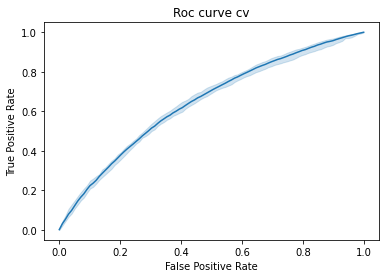

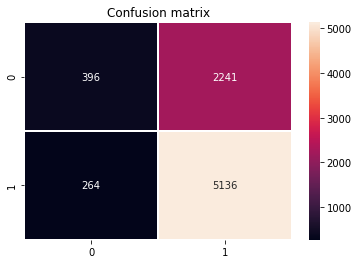

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.60      0.15      0.24      2637
           1       0.70      0.95      0.80      5400

    accuracy                           0.69      8037
   macro avg       0.65      0.55      0.52      8037
weighted avg       0.66      0.69      0.62      8037


*********  AdaBoost Classifier  *********

Score train : 0.69
-----------
Score test : 0.68
-----------
AUC: 0.63 (std:0.0116), (splits = 3)


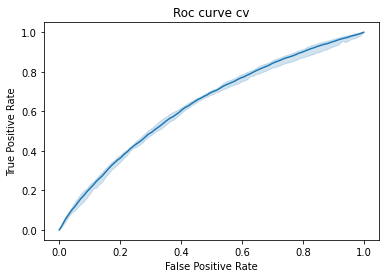

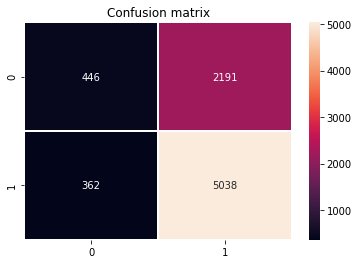

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.55      0.17      0.26      2637
           1       0.70      0.93      0.80      5400

    accuracy                           0.68      8037
   macro avg       0.62      0.55      0.53      8037
weighted avg       0.65      0.68      0.62      8037


*********  XgBoost  *********

Score train : 0.7
-----------
Score test : 0.69
-----------
AUC: 0.64 (std:0.0126), (splits = 3)


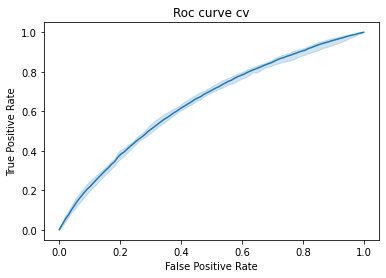

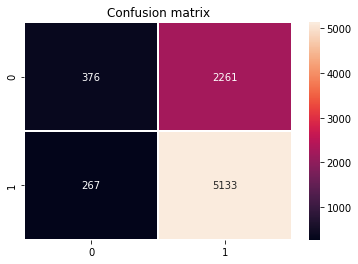

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.58      0.14      0.23      2637
           1       0.69      0.95      0.80      5400

    accuracy                           0.69      8037
   macro avg       0.64      0.55      0.52      8037
weighted avg       0.66      0.69      0.61      8037


*********  Bagging  *********

Score train : 0.97
-----------
Score test : 0.66
-----------
AUC: 0.6 (std:0.0107), (splits = 3)


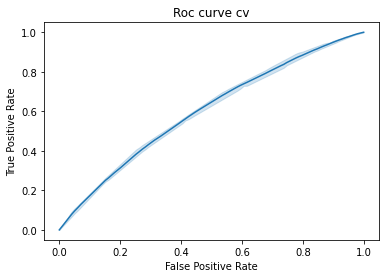

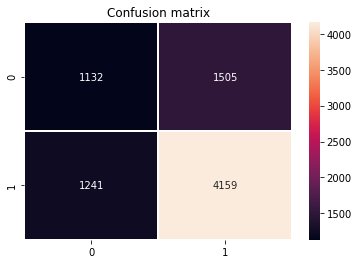

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.48      0.43      0.45      2637
           1       0.73      0.77      0.75      5400

    accuracy                           0.66      8037
   macro avg       0.61      0.60      0.60      8037
weighted avg       0.65      0.66      0.65      8037


*********  Decision Tree  *********

Score train : 0.98
-----------
Score test : 0.62
-----------
AUC: 0.55 (std:0.0037), (splits = 3)


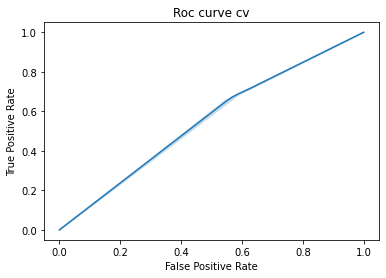

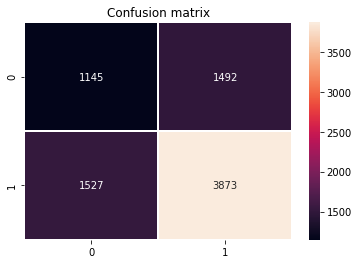

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.43      0.43      0.43      2637
           1       0.72      0.72      0.72      5400

    accuracy                           0.62      8037
   macro avg       0.58      0.58      0.58      8037
weighted avg       0.63      0.62      0.62      8037



In [54]:
for name, model in dict_models.items():
    print("")
    print("********* ",name," *********")
    print("")
    model_fited, _ = MainAiJob(model, df_ph2_clean, target_name='Value_reco', catagorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=False, normalize=True,
                        list_col_name_drop=None,show_explainers=False, calibrate_model=False)

In [55]:
model_selected_ph2 = GradientBoostingClassifier()

Score train : 0.7
-----------
Score test : 0.69
-----------
AUC: 0.65 (std:0.0127), (splits = 3)


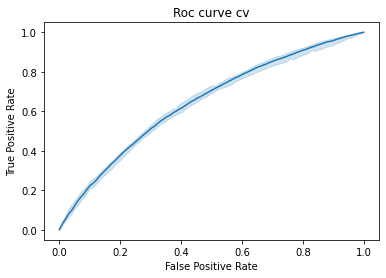

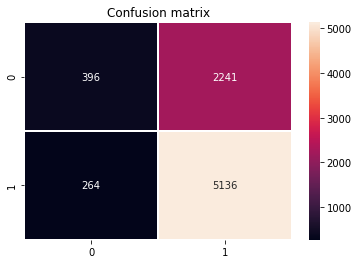

--------
Classification reporting
              precision    recall  f1-score   support

           0       0.60      0.15      0.24      2637
           1       0.70      0.95      0.80      5400

    accuracy                           0.69      8037
   macro avg       0.65      0.55      0.52      8037
weighted avg       0.66      0.69      0.62      8037



In [56]:
model_fited_ph2, core_ph2 = MainAiJob(model_selected_ph2, df_ph2_clean, target_name='Value_reco', catagorical_features=True,
                        test_size=test_size, random_state=random_state, learning_curve_mod=False, normalize=True,
                        list_col_name_drop=None,show_explainers=False, calibrate_model=False)

In [57]:
dump_new_ph2 = False

if dump_new_ph2:
    dump(model_fited_ph2,'../Model/gbc_ph2.joblib')

# Phase 3

In [55]:
df_ph3 = df_ph2.sort_values("Nb_Eval", axis = 0, ascending = False)
df_ph3.shape

(26787, 23)

In [56]:
## je supprime les outliers identifies pendant l'exploration des données

df_ph3 = df_ph3.iloc[150:]
df_ph3 = df_ph3.drop(df_ph3[df_ph3.Price > 300].index)
df_ph3 = df_ph3.drop(df_ph3[df_ph3.Nb_achievements > 6000].index)

df_ph3.shape

(26637, 23)

In [57]:
## and reset index
df_ph3 = df_ph3.reset_index(drop=True)

In [58]:
df_ph3.index

RangeIndex(start=0, stop=26637, step=1)

In [59]:
df_ph3['Nb_Eval_log'] = np.log(df_ph3.Nb_Eval)

<AxesSubplot:>

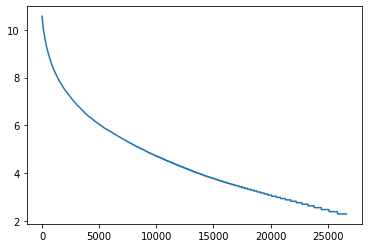

In [60]:
df_ph3['Nb_Eval_log'].plot()

In [61]:
y_full_f3 = df_ph3['Nb_Eval_log'].values

x_full_f3 = df_ph3.drop(['Nb_Eval','Evaluation','status_reco', 'Value_reco','Nb_Eval_log'], axis=1)
x_full_f3.shape, y_full_f3.shape

((26637, 19), (26637,))

In [62]:
seed = 60
np.random.seed(seed)

In [63]:
x_train_f3, x_val_f3, y_train_f3, y_val_f3 = train_test_split(x_full_f3, y_full_f3 , test_size=0.3, random_state=seed)
x_train_f3.shape, x_val_f3.shape, y_train_f3.shape, y_val_f3.shape

((18645, 19), (7992, 19), (18645,), (7992,))

In [64]:
preprocess = make_column_transformer( (MinMaxScaler(), ['Nb_language', 'Nb_achievements',
                                                          'exp_dev_team', 'exp_publish_team','Price']),
                                     (OneHotEncoder(handle_unknown='ignore'),['App_cat', 'Os_supported', 'Prymary_genre',
       'Controller_support', 'Is_free_app', 'Workshop_visible',
       'Only_vr_support', 'Vr_support', 'Has_adult_content',
       'Single_player', 'Coop_player', 'Multi_player', 'Early_Access', 'Self_editor']))

In [65]:
sgd_f3 = make_pipeline(preprocess,PolynomialFeatures(), SGDRegressor())
svrl_f3 = make_pipeline(preprocess,PolynomialFeatures(), svm.LinearSVR(max_iter=1000))
ridg_f3 = make_pipeline(preprocess,PolynomialFeatures(), Ridge(max_iter=500))
svr_f3 = make_pipeline(preprocess, svm.SVR(C=1,kernel='poly'))

In [66]:
dict_models_f3 ={"SGD": sgd_f3,"SVRLR": svrl_f3,"Ridge": ridg_f3,"SVR": svr_f3}

In [67]:
def f3_eval(pip,x_train, x_val, y_train, y_val):
    print("---------------")
    pip.fit(x_train,y_train);
    y_valid_pred = pip.predict(x_val)

    pred_ref = np.exp(y_valid_pred)

    y_val_rescale = y_val.reshape(y_val.shape[0])
    y_val_rescale = np.exp(y_val_rescale)

    RMSE = np.sqrt(MSE(pred_ref, y_val_rescale))
    print('RMSE : ', RMSE.round(4))

    score = MAE(pred_ref, y_val_rescale)
    print('MAE : ', round(score,4))

    plt.figure()
    sns.regplot(pred_ref, y_val_rescale, color="g")
    plt.show()
    print("---------------")

SGD
---------------
RMSE :  2553.0316
MAE :  642.7382


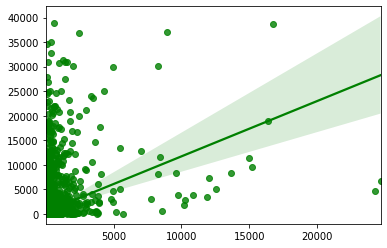

---------------
SVRLR
---------------


Liblinear failed to converge, increase the number of iterations.


RMSE :  2528.8021
MAE :  633.9448


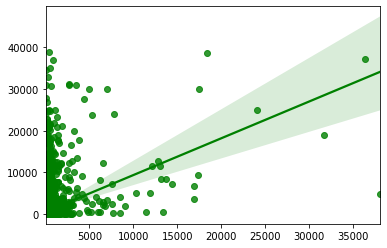

---------------
Ridge
---------------
RMSE :  2547.3408
MAE :  633.5559


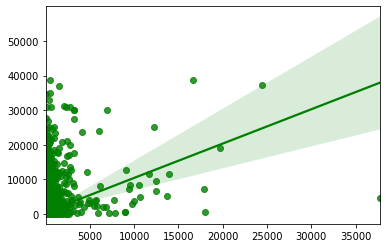

---------------
SVR
---------------
RMSE :  2576.702
MAE :  636.7421


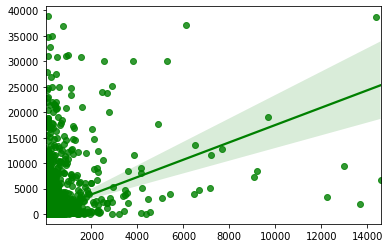

---------------


In [68]:
for name, model in dict_models_f3.items():
    print(name)
    f3_eval(model,x_train_f3, x_val_f3, y_train_f3, y_val_f3)

In [69]:
svr_f3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Nb_language',
                                                   'Nb_achievements',
                                                   'exp_dev_team',
                                                   'exp_publish_team',
                                                   'Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['App_cat', 'Os_supported',
                                                   'Prymary_genre',
                                                   'Controller_support',
                                                   'Is_free_app',
                                                   '

In [70]:
dump_new_ph3 = False

if dump_new_ph3 :
    dump(svr_f3, '../Model/svr_f3.joblib')